In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.utils.fixes import loguniform

import scipy.stats as stats

from ts_utils import OOSR2

In [2]:
df = pd.read_csv("../_data/time_series.csv", index_col="Date")
df.index = pd.to_datetime(df.index)
df = df.round(4)

train = df.loc[df.index <= "2009.12.31"]
test = df.loc[df.index > "2009.12.31"]

train.shape, test.shape

((357, 51), (357,), (158, 51), (158,))

In [7]:
bestparams = []
predictions = []
naive_predictions = []
train_end_dates = []

naive_mean = DummyRegressor(strategy="mean")

for i in np.arange(357,515,6):
    train_realtime = df.iloc[:i]
    test_realtime = df.iloc[i:i+6]
    
    X_train, y_train = train_realtime.drop(["EXCESS_RETURN_T+1"], axis=1).values, train_realtime["EXCESS_RETURN_T+1"].values
    X_test, y_test = test_realtime.drop(["EXCESS_RETURN_T+1"], axis=1).values, test_realtime["EXCESS_RETURN_T+1"].values
    
    pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("regressor", ElasticNet()) 
    ])

    param_grid = {
    'regressor__alpha': stats.uniform(0.001,1),
    "regressor__l1_ratio": stats.uniform(0,1)  
}

    tscv = TimeSeriesSplit(n_splits=2)

    grid_search = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions = param_grid,
    scoring= "neg_mean_squared_error",
    refit= "neg_mean_squared_error", 
    cv=tscv, 
    n_jobs=-1,
    n_iter=1000
    )

    grid_search.fit(X_train, y_train)
    naive_mean.fit(X_train, y_train)

    predictions.extend(grid_search.predict(X_test).tolist())
    naive_predictions.extend(naive_mean.predict(X_test).tolist())
    train_end_dates.append(pd.to_datetime(train_realtime.index[-1]).strftime('%Y-%m-%d'))
    bestparams.append(grid_search.best_params_)

In [8]:
OOSR2(test["EXCESS_RETURN_T+1"].values, np.array(predictions), np.array(naive_predictions))

0.011473016654443335

[]

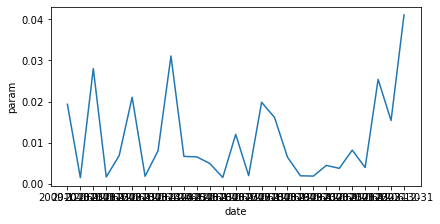

In [9]:
alphalist = []
l1list = []

for paramdict in bestparams:
    alphalist.append(paramdict["regressor__alpha"])
    l1list.append(paramdict["regressor__l1_ratio"])
    
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.plot(train_end_dates, alphalist)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()

[]

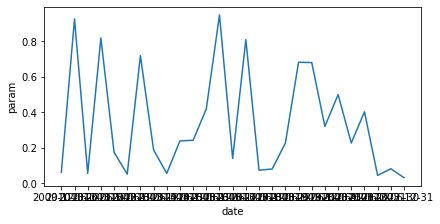

In [10]:
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.plot(train_end_dates, l1list)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()

In [11]:
rfr = pd.read_csv("../_data/rfr_02_2010_to_03_2023_158vals.csv", index_col="Date")
econeval = pd.DataFrame()
econeval["r"] = test["EXCESS_RETURN_T+1"]
econeval["r_predict"] = predictions
econeval["mean_predict"] = naive_predictions
econeval["rfr"] = rfr["RF"].values
econeval.index = rfr.index
econeval["vola_est"] = econeval["r"].rolling(window=12, closed="left").std()
econeval["w_model"] = 1/3*econeval["r_predict"]/econeval["vola_est"]**2
econeval["w_mean"] = 1/3*econeval["mean_predict"]/econeval["vola_est"]**2
econeval["w_model_cap"] = econeval["w_model"].apply(lambda x: 1 if x > 1 else (0 if x < 0 else x))
econeval["w_mean_cap"] = econeval["w_mean"].apply(lambda x: 1 if x > 1 else (0 if x < 0 else x))
econeval["rp_model"] = econeval["rfr"]+econeval["w_model_cap"]*econeval["r"]
econeval["rp_mean"] = econeval["rfr"]+econeval["w_mean_cap"]*econeval["r"]

In [12]:
econeval.dropna(axis=0,inplace=True)
u_model = econeval["rp_model"].mean() - 0.5*3*econeval["rp_mean"].std()**2
u_mean = econeval["rp_mean"].mean() - 0.5*3*econeval["rp_mean"].std()**2
annualized_gain = (u_model - u_mean)*12
monthly_sharpe = econeval["rp_model"].mean() / econeval["rp_model"].std()
sp500meanreturn = econeval["r"].mean()
sp500vol = econeval["r"].std()

print("annualized gain: ", annualized_gain)
print("monthly avg portfolio return: ", econeval["rp_model"].mean())
print("monthly volatility: ", econeval["rp_model"].std())
print("monthly sharpe: ", monthly_sharpe)
print("sp500 mean return:",sp500meanreturn)
print("sp500 vola:",sp500vol)

annualized gain:  0.01042635597281276
monthly avg portfolio return:  0.006548372862983603
monthly volatility:  0.030934839882279724
monthly sharpe:  0.21168277863738613
sp500 mean return: 0.008317123287671233
sp500 vola: 0.0419887429242304
